In [11]:
# Cell 1 — Environment setup (run first)
!pip install wordcloud --quiet
!pip install nltk --quiet

# Download only stopwords from nltk (allowed)
import nltk
nltk.download('stopwords', quiet=True)

# Standard imports
import re
import string
import math
from collections import Counter, defaultdict
from itertools import islice
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
from typing import List, Optional, Any


%matplotlib inline

print("Environment ready.")


Environment ready.


In [12]:
# Cell 2 — Q1: TOC Tree Implementation
from typing import List, Optional, Any

class Node:
    """
    A generic tree node for Table-of-Contents.
    Attributes:
        title (str): Title of this node (chapter/section/etc)
        children (list[Node]): Ordered list of children nodes
    """
    def __init__(self, title: str):
        self.title = title
        self.children: List['Node'] = []

    def add_child(self, node: 'Node'):
        self.children.append(node)

class BookTOC:
    """
    Book Table-of-Contents tree with insertion and traversal operations.
    Uses pre-order DFS to maintain human-ordered TOC traversal.
    """
    def __init__(self, root_title: str = "Book"):
        self.root = Node(root_title)

    def insert(self, path: List[int], title: str):
        """
        Insert a node given a numeric path. Examples:
          [3] -> Chapter 3 (child index 2)
          [3,2] -> Chapter 3 -> Subchapter 2
          [3,2,5] -> Chapter 3 -> Subchapter 2 -> Sub-subchapter 5
        Path indices are 1-based for user convenience. Missing intermediate nodes are created with placeholder titles.
        """
        assert all(isinstance(i, int) and i >= 1 for i in path), "Path must be list of 1-based positive ints."
        node = self.root
        for level_index, idx in enumerate(path):
            # convert to 0-based index
            desired_pos = idx - 1
            while len(node.children) <= desired_pos:
                # create placeholder nodes so structure always exists
                placeholder_title = f"Placeholder level{level_index+1} index{len(node.children)+1}"
                node.add_child(Node(placeholder_title))
            node = node.children[desired_pos]
        # Set the title
        node.title = title

    def _print_plain(self, node: Optional[Node] = None, out: Optional[list] = None):
        if out is None:
            out = []
        if node is None:
            node = self.root
        out.append(node.title)
        for c in node.children:
            self._print_plain(c, out)
        return out

    def _print_indented(self, node: Optional[Node] = None, level: int = 0, out: Optional[list] = None):
        if out is None:
            out = []
        if node is None:
            node = self.root
        out.append(("  " * level) + node.title)
        for c in node.children:
            self._print_indented(c, level + 1, out)
        return out

    def _print_numbered(self, node: Optional[Node] = None, prefix: List[int] = None, out: Optional[list] = None):
        """
        Numbering: root is unnumbered; children numbered like 1, 1.1, 1.1.1, etc.
        """
        if out is None:
            out = []
        if prefix is None:
            prefix = []
        if node is None:
            node = self.root

        if prefix:
            label = ".".join(map(str, prefix))
            out.append(f"{label} {node.title}")
        else:
            out.append(node.title)  # root
        for i, c in enumerate(node.children, start=1):
            self._print_numbered(c, prefix + [i], out)
        return out

    def print_toc(self, mode: str = "numbered"):
        """
        mode in {'plain', 'indented', 'numbered'}
        """
        if mode == "plain":
            out = self._print_plain()
        elif mode == "indented":
            out = self._print_indented()
        else:
            out = self._print_numbered()
        for line in out:
            print(line)

    def depth(self, node_title: str) -> int:
        """
        Return depth (distance from root) of first node matching node_title.
        Root depth = 0. Returns -1 if not found.
        """
        def dfs(n, depth):
            if n.title == node_title:
                return depth
            for c in n.children:
                d = dfs(c, depth + 1)
                if d != -1:
                    return d
            return -1
        return dfs(self.root, 0)

    def height(self) -> int:
        """
        Return height of tree = max depth from root to any leaf.
        """
        def h(n):
            if not n.children:
                return 0
            return 1 + max(h(c) for c in n.children)
        return h(self.root)

# Simple unit-tests / demonstration
def _test_toc():
    toc = BookTOC("Deep Learning Book")
    # build first 3 chapters each with 2 subchapters, each with 2 sub-subchapters
    for ch in range(1, 4):
        toc.insert([ch], f"Chapter {ch} Title")
        for sc in range(1, 3):
            toc.insert([ch, sc], f"Chapter {ch} - Section {sc}")
            for ssc in range(1, 3):
                toc.insert([ch, sc, ssc], f"Chapter {ch}.{sc}.{ssc} Topic")
    # print examples
    print("=== Numbered TOC ===")
    toc.print_toc("numbered")
    print("\n=== Indented TOC ===")
    toc.print_toc("indented")
    # tests
    assert toc.depth("Chapter 1 Title") == 1
    assert toc.depth("Chapter 1.1.2 Topic") == 3
    assert toc.height() >= 3
    print("\nTOC tests passed.")

_test_toc()


=== Numbered TOC ===
Deep Learning Book
1 Chapter 1 Title
1.1 Chapter 1 - Section 1
1.1.1 Chapter 1.1.1 Topic
1.1.2 Chapter 1.1.2 Topic
1.2 Chapter 1 - Section 2
1.2.1 Chapter 1.2.1 Topic
1.2.2 Chapter 1.2.2 Topic
2 Chapter 2 Title
2.1 Chapter 2 - Section 1
2.1.1 Chapter 2.1.1 Topic
2.1.2 Chapter 2.1.2 Topic
2.2 Chapter 2 - Section 2
2.2.1 Chapter 2.2.1 Topic
2.2.2 Chapter 2.2.2 Topic
3 Chapter 3 Title
3.1 Chapter 3 - Section 1
3.1.1 Chapter 3.1.1 Topic
3.1.2 Chapter 3.1.2 Topic
3.2 Chapter 3 - Section 2
3.2.1 Chapter 3.2.1 Topic
3.2.2 Chapter 3.2.2 Topic

=== Indented TOC ===
Deep Learning Book
  Chapter 1 Title
    Chapter 1 - Section 1
      Chapter 1.1.1 Topic
      Chapter 1.1.2 Topic
    Chapter 1 - Section 2
      Chapter 1.2.1 Topic
      Chapter 1.2.2 Topic
  Chapter 2 Title
    Chapter 2 - Section 1
      Chapter 2.1.1 Topic
      Chapter 2.1.2 Topic
    Chapter 2 - Section 2
      Chapter 2.2.1 Topic
      Chapter 2.2.2 Topic
  Chapter 3 Title
    Chapter 3 - Section 1
     

### Cell 3 — Notes on design choices for Q1 (put in notebook markdown cell)
### Design notes (short)
 - Node + BookTOC chosen (Case A) for simplicity and flexible insertion.
 - Traversal: Pre-order DFS to preserve reading order (chapter before its subchapters).
 - insert uses 1-based numeric path (common for TOC numbering).
 - depth(title) does a DFS search; height() computed recursively.
 - Complexity: insertion takes O(depth) per insert (depth typically small). Traversals are O(n).


In [13]:
# === Cell: download the Project Gutenberg plain-text of Notre-Dame de Paris ===
# (Project Gutenberg file index shows 2610-0.txt as the plain text for ebook #2610)
!wget -q -O /content/notre_dame_2610.txt https://www.gutenberg.org/files/2610/2610-0.txt

novel_path = '/content/notre_dame_2610.txt'
print("Saved novel to:", novel_path)

# Quick verification (print first 10 lines)
with open(novel_path, 'r', encoding='utf-8', errors='ignore') as f:
    for _ in range(10):
        print(f.readline().rstrip())


Saved novel to: /content/notre_dame_2610.txt
﻿The Project Gutenberg eBook of Notre-Dame de Paris, by Victor Hugo

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.



In [14]:
# Cell 4 — Q2: Text analysis utilities
import nltk
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def load_text(path: str, encoding='utf-8') -> str:
    """
    Load text from a file path. Returns raw string.
    """
    with open(path, 'r', encoding=encoding, errors='ignore') as f:
        return f.read()

def preprocess_text(raw: str, keep_apostrophe_inside_word: bool = True):
    """
    Preprocess text:
      - lowercases
      - optionally keeps internal apostrophes (e.g., don't -> don't)
      - removes punctuation/digits (except allowed apostrophes)
      - tokenizes by whitespace
      - returns: cleaned_text (str), tokens (list), token_count_before (int), token_count_after (int)
    """
    raw_lower = raw.lower()
    # optional: normalize unicode, etc (skipped for brevity)
    token_before = raw_lower.split()
    token_count_before = len(token_before)

    if keep_apostrophe_inside_word:
        # replace punctuation except apostrophe
        # we remove digits and punctuation except apostrophe
        allowed = "'"
        # build translation table for punctuation/digits removal (except apostrophe)
        remove_chars = ''.join(ch for ch in string.punctuation if ch not in allowed) + string.digits
        trans = str.maketrans({c: " " for c in remove_chars})
        cleaned = raw_lower.translate(trans)
        # collapse multiple whitespace
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    else:
        # remove all punctuation and digits
        trans = str.maketrans({c: " " for c in string.punctuation + string.digits})
        cleaned = raw_lower.translate(trans)
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    # tokenization by whitespace
    tokens = cleaned.split()
    token_count_after = len(tokens)

    return cleaned, tokens, token_count_before, token_count_after

def remove_stopwords(tokens: List[str], stopword_set: set = STOPWORDS):
    kept = [t for t in tokens if t not in stopword_set]
    removed_count = len(tokens) - len(kept)
    return kept, removed_count

def letter_frequency(text: str):
    """
    Returns Counter for letters a-z and total letters counted.
    """
    letters = re.findall(r'[a-z]', text.lower())
    c = Counter(letters)
    total = sum(c.values())
    return c, total

def ngram_counts(tokens: List[str], n: int):
    """
    Return Counter of n-grams (joined by space). O(len(tokens) * n)
    """
    if n <= 0:
        return Counter()
    ngrams = (" ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1))
    return Counter(ngrams)

# Simple visualization helpers
def plot_letter_freq(counter: Counter, total_letters: int, top_n: int = 26):
    df = pd.DataFrame([(k, counter.get(k,0), counter.get(k,0)/total_letters if total_letters>0 else 0) for k in list("abcdefghijklmnopqrstuvwxyz")],
                      columns=['letter','count','prop'])
    df.plot.bar(x='letter', y='count', legend=False, figsize=(12,4))
    plt.title("Letter frequency (a-z)")
    plt.ylabel("count")
    plt.show()

def plot_top_words(counter: Counter, top_k: int = 40):
    top = counter.most_common(top_k)
    df = pd.DataFrame(top, columns=['word','count'])
    df.plot.bar(x='word', y='count', legend=False, figsize=(14,5))
    plt.xticks(rotation=90)
    plt.title(f"Top {top_k} words")
    plt.show()

def wordcloud_from_counter(counter: Counter, max_words=200):
    wc = WordCloud(width=800, height=400)
    wc.generate_from_frequencies(counter)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()


Tokens before preprocessing (split raw): 187,642
Tokens after cleaning & tokenization: 192,643
Stopwords removed: 92,310; tokens after stopword removal: 100,333
Total letters counted: 840,889


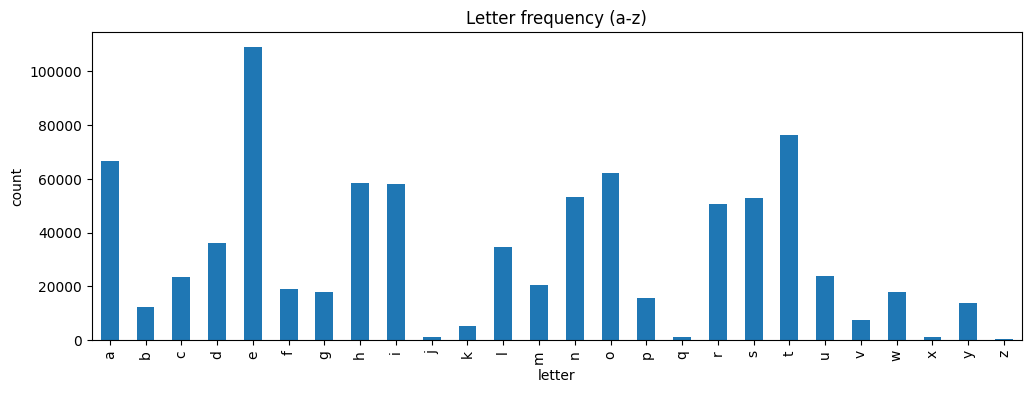

Unique words after stopword removal: 14,815


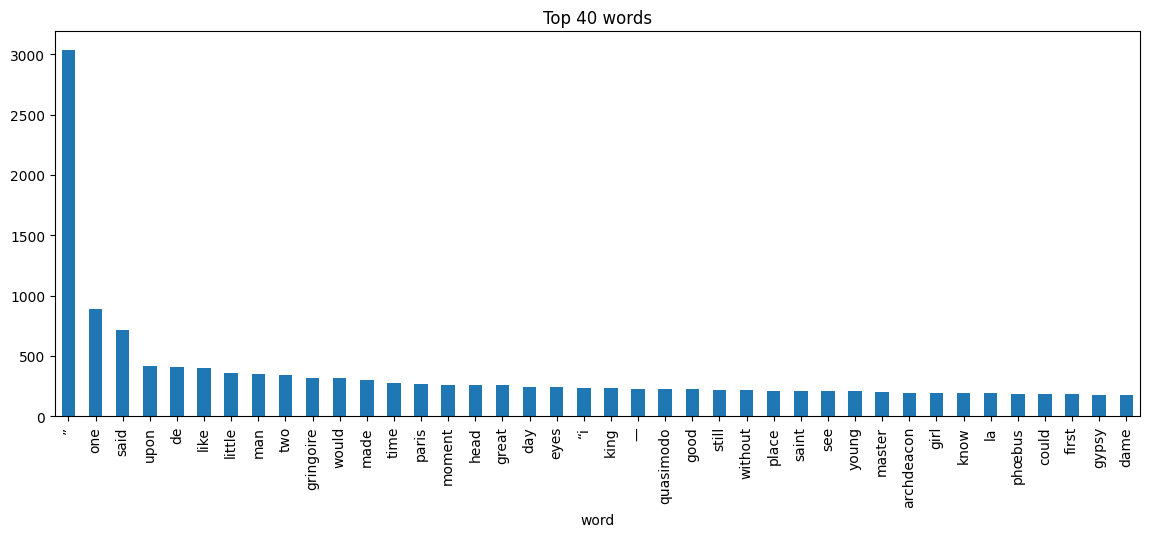

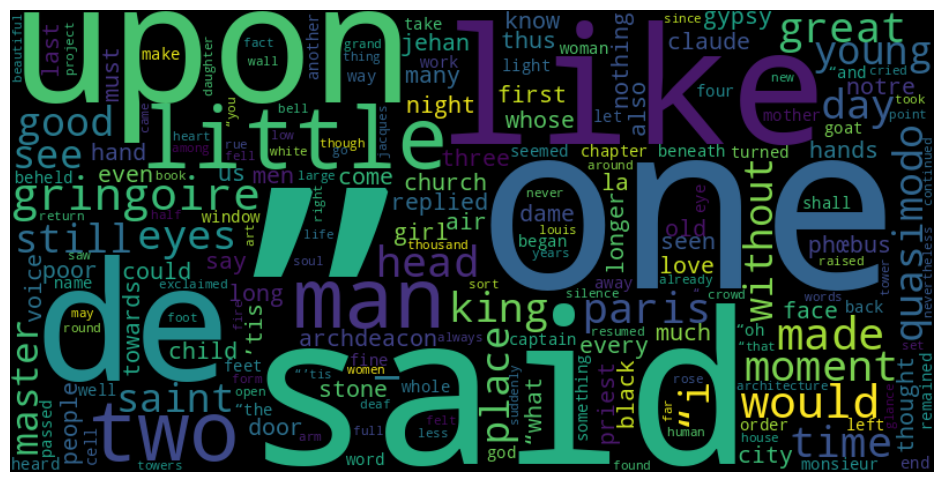

Top Bigrams:
” said -> 539
notre dame -> 141
” replied -> 134
young girl -> 107
” “i -> 79
” exclaimed -> 67
” cried -> 64
” resumed -> 64
fleur de -> 62
dom claude -> 61
louis xi -> 58
de lys -> 56
project gutenberg™ -> 56
said gringoire -> 50
la esmeralda -> 47
” “and -> 46
one would -> 44
de la -> 43
claude frollo -> 42
let us -> 40

Top Trigrams:
fleur de lys -> 56
” said gringoire -> 49
” said king -> 22
place de grève -> 19
one would said -> 19
“oh ” said -> 19
palais de justice -> 18
rue de la -> 18
” said archdeacon -> 18
project gutenberg™ electronic -> 18
phœbus de châteaupers -> 17
” said priest -> 16
dame de paris -> 15
” said jehan -> 15
” “yes ” -> 15
“i know ” -> 14
” “i know -> 14
one would pronounced -> 13
project gutenberg literary -> 13
gutenberg literary archive -> 13


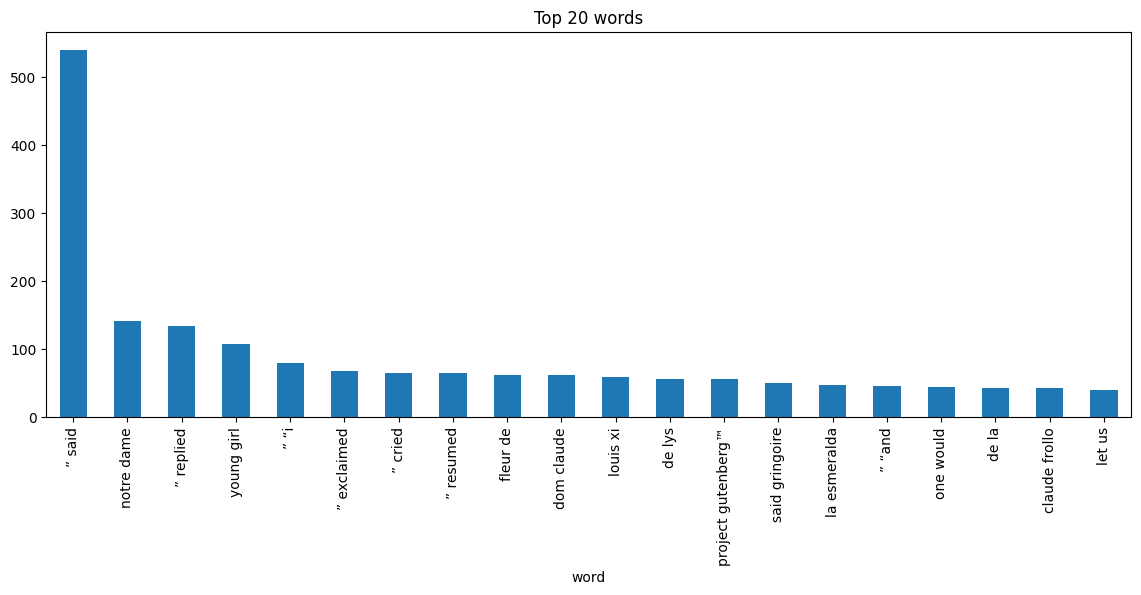

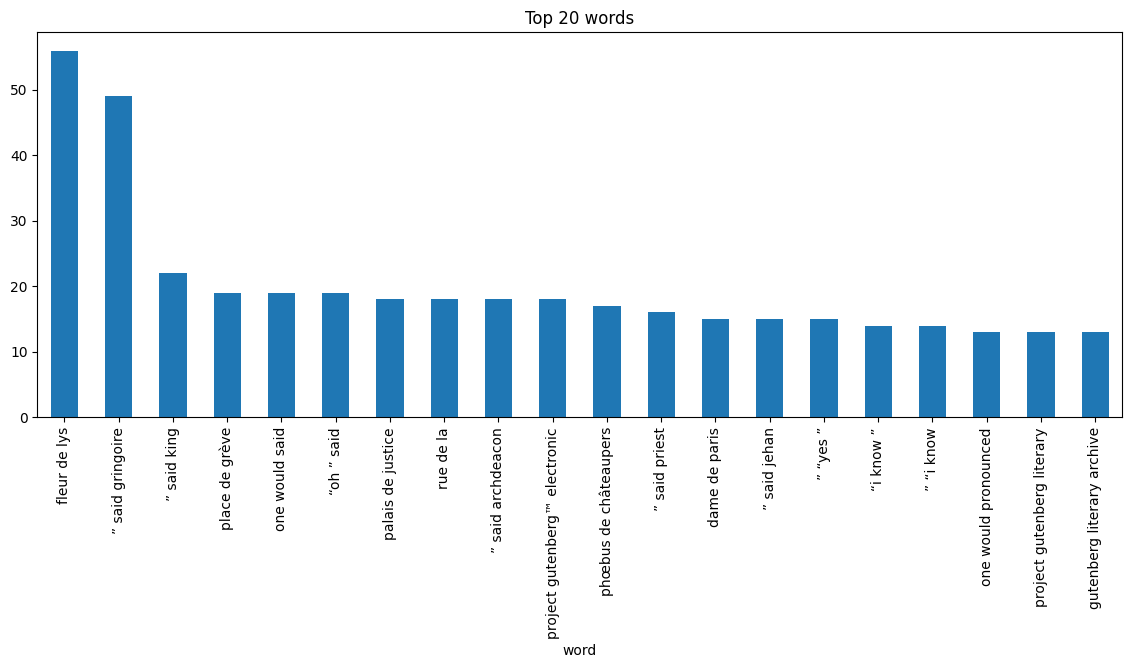

In [15]:
# Cell 5 — Q2: End-to-end analysis function and example usage
def analyze_novel(novel_path: str, keep_apostrophe_inside_word: bool = True, top_words=40, top_bigrams=20, top_trigrams=20):
    """
    Runs the full Q2 pipeline on a novel text file.
    Returns a dict of computed objects and shows plots.
    """
    raw = load_text(novel_path)
    cleaned_text, tokens, before, after = preprocess_text(raw, keep_apostrophe_inside_word)
    print(f"Tokens before preprocessing (split raw): {before:,}")
    print(f"Tokens after cleaning & tokenization: {after:,}")

    # Stopword removal
    tokens_nostop, removed_count = remove_stopwords(tokens, STOPWORDS)
    print(f"Stopwords removed: {removed_count:,}; tokens after stopword removal: {len(tokens_nostop):,}")

    # Letter frequencies
    letter_cnt, total_letters = letter_frequency(cleaned_text)
    print(f"Total letters counted: {total_letters:,}")
    plot_letter_freq(letter_cnt, total_letters)

    # Word frequencies
    word_cnt = Counter(tokens_nostop)
    print(f"Unique words after stopword removal: {len(word_cnt):,}")
    plot_top_words(word_cnt, top_words)
    wordcloud_from_counter(word_cnt, max_words=200)

    # Bigrams & Trigrams
    bigrams = ngram_counts(tokens_nostop, 2)
    trigrams = ngram_counts(tokens_nostop, 3)
    print("Top Bigrams:")
    for b,c in bigrams.most_common(top_bigrams):
        print(f"{b} -> {c}")
    print("\nTop Trigrams:")
    for t,c in trigrams.most_common(top_trigrams):
        print(f"{t} -> {c}")

    # Visualize bigrams/trigrams (bars)
    plot_top_words(bigrams, top_bigrams)
    plot_top_words(trigrams, top_trigrams)

    # Complexity notes (returned for inclusion in report)
    complexity = {
        'preprocessing': "O(N) where N is number of characters/tokens (single pass to clean & tokenize)",
        'counts': "O(T) where T is number of tokens for unigram counts; O(T) for n-gram generation for fixed small n",
    }

    results = {
        'raw_text': raw,
        'cleaned_text': cleaned_text,
        'tokens_before': before,
        'tokens_after': after,
        'tokens_nostop': tokens_nostop,
        'letter_counter': letter_cnt,
        'total_letters': total_letters,
        'word_counter': word_cnt,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'complexity': complexity
    }
    return results

results = analyze_novel(novel_path)


In [16]:



# Cell 6 — Extra: sentence-structure metrics (challenge)
def sentence_metrics(raw_text: str):
    """
    Basic sentence metrics:
      - average words per sentence
      - most common sentence starters (first word after sentence split)
      - sentence length distribution
    Note: sentence splitting by [.!?] is simplistic but permitted here (no NLP libs).
    """
    # Split sentences by ., !, ? — keep simple
    sentences = re.split(r'[.!?]+', raw_text)
    sentences = [s.strip() for s in sentences if s.strip()]
    word_counts = []
    starters = Counter()
    for s in sentences:
        # tokenize similarly: lowercase, remove extra punctuation
        s_clean = re.sub(r'[^a-zA-Z\'\s]', ' ', s).lower()
        toks = [t for t in s_clean.split() if t]
        if toks:
            word_counts.append(len(toks))
            starters[toks[0]] += 1
    avg_words = sum(word_counts)/len(word_counts) if word_counts else 0
    distribution = Counter(word_counts)
    common_starters = starters.most_common(20)
    return {
        'num_sentences': len(sentences),
        'avg_words_per_sentence': avg_words,
        'sentence_length_distribution': distribution,
        'common_sentence_starters': common_starters
    }



In [17]:
import re
import pandas as pd

# Read the text of the book from novel_path
with open(novel_path, 'r', encoding='utf-8') as f:
    book_text = f.read()

# Split text into chapters using a regex pattern
# Works for "CHAPTER I", "CHAPTER II", etc.
chapters = re.split(r'\bCHAPTER [IVXLCDM]+\b', book_text, flags=re.IGNORECASE)

# The first element is usually the preface or header, so skip it
chapters = [ch.strip() for ch in chapters if len(ch.strip()) > 500]

# Run sentence_metrics() on each chapter and store results
chapter_results = []
for i, ch in enumerate(chapters, start=1):
    print(f"Processing Chapter {i}...")
    metrics = sentence_metrics(ch)
    metrics["chapter"] = i
    chapter_results.append(metrics)

# Combine results into a DataFrame for summary
results_df = pd.DataFrame(chapter_results)

# Display summary
print("\n✅ Sentence metrics by chapter:")
display(results_df.head())

# Optionally, save to CSV
results_df.to_csv("sentence_metrics_by_chapter.csv", index=False)


Processing Chapter 1...
Processing Chapter 2...
Processing Chapter 3...
Processing Chapter 4...
Processing Chapter 5...
Processing Chapter 6...
Processing Chapter 7...
Processing Chapter 8...
Processing Chapter 9...
Processing Chapter 10...
Processing Chapter 11...
Processing Chapter 12...
Processing Chapter 13...
Processing Chapter 14...
Processing Chapter 15...
Processing Chapter 16...
Processing Chapter 17...
Processing Chapter 18...
Processing Chapter 19...
Processing Chapter 20...
Processing Chapter 21...
Processing Chapter 22...
Processing Chapter 23...
Processing Chapter 24...
Processing Chapter 25...
Processing Chapter 26...
Processing Chapter 27...
Processing Chapter 28...
Processing Chapter 29...
Processing Chapter 30...
Processing Chapter 31...
Processing Chapter 32...
Processing Chapter 33...
Processing Chapter 34...
Processing Chapter 35...
Processing Chapter 36...
Processing Chapter 37...
Processing Chapter 38...
Processing Chapter 39...
Processing Chapter 40...
Processin

,num_sentences,avg_words_per_sentence,sentence_length_distribution,common_sentence_starters,chapter
0,22,22.272727,"{41: 1, 27: 3, 1: 3, 16: 3, 49: 1, 2: 4, 36: 1...","[(the, 3), (hapgood, 2), (you, 1), (gutenberg,...",1
1,290,18.155172,"{3: 13, 40: 2, 16: 7, 23: 5, 54: 2, 17: 5, 41:...","[(the, 34), (it, 19), (and, 17), (down, 8), (a...",2
2,193,16.890625,"{2: 18, 47: 2, 3: 12, 23: 2, 8: 9, 11: 5, 5: 1...","[(the, 26), (and, 12), (he, 9), (it, 8), (said...",3
3,85,29.258824,"{3: 5, 2: 3, 94: 1, 13: 3, 10: 3, 51: 1, 42: 1...","[(the, 9), (it, 6), (all, 5), (he, 4), (a, 4),...",4
4,174,18.977011,"{3: 9, 57: 1, 17: 6, 14: 8, 6: 9, 9: 1, 7: 6, ...","[(the, 18), (this, 9), (but, 8), (what, 6), (h...",5


In [18]:
# Cell 7 — Basic unit-tests for Q2 functions (assertions)
def _test_text_utils():
    sample = "Hello, world! Don't stop. The data's great; it's 2025."
    cleaned, tokens, b, a = preprocess_text(sample)
    assert 'hello' in tokens
    assert "don't" in tokens or "dont" in tokens  # depending on apostrophe handling
    kept, removed = remove_stopwords(tokens, STOPWORDS)
    assert isinstance(kept, list)
    lc, total = letter_frequency(sample)
    assert total > 0
    n2 = ngram_counts(['a','b','c','d'], 2)
    assert n2['a b'] == 1
    print("Text utils tests passed.")

_test_text_utils()


Text utils tests passed.
